# Laboration deep learning AI21

## 0. EDA och filhantering

Creating the folders with python :

In [89]:
import os , random, shutil, glob, cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

In [90]:
parent_dir = os.getcwd() #get actual directory
main_folders = ["experiment_small_data","experiment_tiny_data","original_data"]
subfolders = ["experiment_small_data/test","experiment_small_data/train","experiment_small_data/val","experiment_tiny_data/test","experiment_tiny_data/train","experiment_tiny_data/val","original_data/train","original_data/test"]

for main_f in main_folders :
    for sub_f in subfolders : 
        sub_f_list = sub_f.split("/") # turn subfolder path into list of folders
        if main_f in sub_f_list : 
            directory_name = sub_f_list[1] #actual directory to make is the 2nd in the list
            path = os.path.join(parent_dir,main_f,directory_name) #creating the folder path
            if not os.path.isdir(path): # check if path doesn't already exist
                try: 
                    os.makedirs(path) #create all missing folders in the folder path 
                except OSError as error: 
                    print(error)

Read in 10 pictures randomly and plot them out, use the label as plot title :

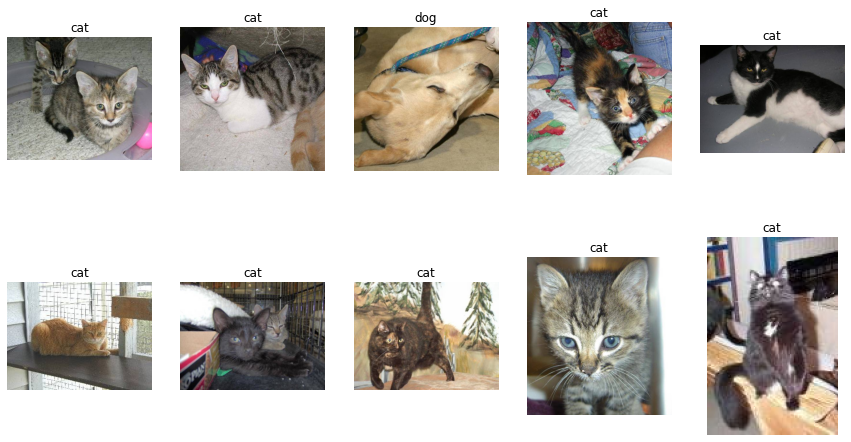

In [91]:
folder = "original_data/train/train" #source folder for all labeled images

files = random.sample(glob.glob(parent_dir+"/"+folder+"/*.jpg"), 10) # getting a random sample of 10 jpg files from directory

fig, axes = plt.subplots(2,5, figsize=(15,8))
for file_path,(i, ax) in zip(files,enumerate(axes.flatten())) : 
    label = file_path.split("/")[-1].split(".")[0] # getting the label from the path
    image = plt.imread(file_path) # read image with plt imread method
    ax.imshow(image) 
    ax.set_title(f"{label}")
    ax.axis("off")


Split the data into train / validation / test :

In [92]:
# splitting the data 

folder_for = lambda x : os.path.join(parent_dir,data,x) #creates folder path
source_folder = os.path.join(parent_dir,"original_data/train/train") # source of all pictures we will use for train|val|test

data_names = ["experiment_small_data","experiment_tiny_data"]
samples_sizes = [(800,200,250),(80,20,25)]

for data,sample_size in zip(data_names,samples_sizes): #loop simultaneously through folder names and samples size
    train_size,val_size, test_size = sample_size # pick the train,val,test sizes

    animal_list = lambda x : [x+"."+str(y)+".jpg" for y in random.sample(range(1,12500),sum(sample_size))] # returns a list of randomly picked files for a specific label
    cats = animal_list("cat") 
    dogs = animal_list("dog") 

    #loop trough our ranges and subfolder names (ex : train will have a range 0:800 or 0:80 depending on tiny or small data)
    for (start,end),trainvaltest in zip([(0,train_size),(train_size,train_size+val_size),(train_size+val_size,len(cats))],["train","val","test"]):
        if len(glob.glob(folder_for(trainvaltest)+"/*.jpg")) == 0: # check if destination folder is empty
            for cat_picture,dog_picture in zip(cats[start:end],dogs[start:end]): # loop through the cats and dogs files list and copy them into destination folder
                shutil.copy(os.path.join(source_folder,cat_picture),folder_for(trainvaltest))
                shutil.copy(os.path.join(source_folder,dog_picture),folder_for(trainvaltest))

        else : 
            print(data,"/",trainvaltest," folder already filled, please empty the folder and try again")

experiment_small_data / train  folder already filled, please empty the folder and try again
experiment_small_data / val  folder already filled, please empty the folder and try again
experiment_small_data / test  folder already filled, please empty the folder and try again
experiment_tiny_data / train  folder already filled, please empty the folder and try again
experiment_tiny_data / val  folder already filled, please empty the folder and try again
experiment_tiny_data / test  folder already filled, please empty the folder and try again


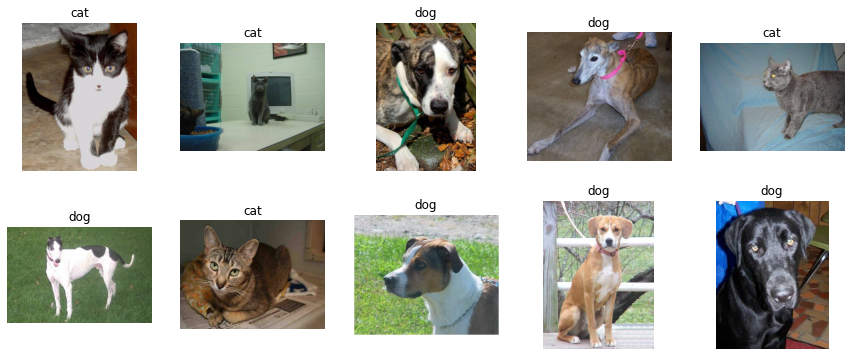

In [93]:
# get a sample of 5 randomly chosen pictures from each of small and tiny data
s_images = random.sample(glob.glob(parent_dir+"/"+"experiment_small_data"+"/train/*.jpg"),5)
t_images = random.sample(glob.glob(parent_dir+"/"+"experiment_tiny_data"+"/val/*.jpg"),5)

fig,ax = plt.subplots(2,5,figsize = (15,6))

#plot 
for path,axe in zip(s_images+t_images,ax.flatten()) : 
    label = path.split("/")[-1].split(".")[0]
    image = plt.imread(path)
    axe.imshow(image)
    axe.set_title(label)
    axe.axis("off")



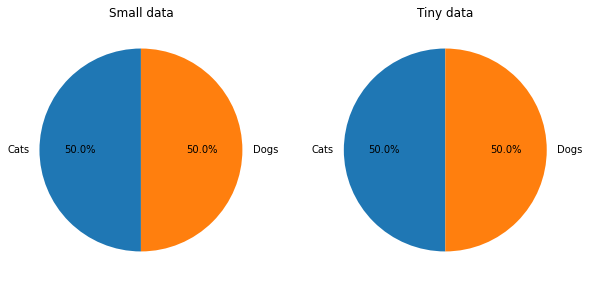

In [94]:
#Checking if the data is well balanced 

def get_proportions(folder_path): # returns a list of 2 values for dogs and cats amounts in folder
        data_dogs = 0
        data_cats = 0
        for file_path in glob.glob(parent_dir+"/"+folder_path+"/train/*.jpg"): # go though all jpg files in directory
                label = file_path.split("/")[-1].split(".")[0] #get label
                if label == "dog" : 
                        data_dogs += 1
                else : 
                        data_cats += 1 
        return [data_cats,data_dogs]

fig, ax = plt.subplots(1,2,figsize=(10,5))

# looping through axes and folder path as well as data name to plot the pie charts
for (folder_path, data_name), axe in zip([("experiment_small_data","Small data"),("experiment_tiny_data","Tiny data")],ax.flatten()):
        axe.pie(get_proportions(folder_path=folder_path), 
                labels=["Cats","Dogs"], 
                startangle=90, 
                autopct='%1.1f%%'
                )
        axe.set_title(data_name)

plt.show()

In [95]:
#creating the dataframes 

label_of = lambda x: x.split("/")[-1].split(".")[0] # return label from file path
small = "experiment_small_data"
tiny = "experiment_tiny_data"

def create_dataframe(folder,subfolder): # returns the dataframe from the images of a subfolder
    #create and shuffle the list of lists of file paths and labels before creating the dataframe
    data = shuffle([[file_path,1 if label_of(file_path)=="dog" else 0] for file_path in glob.glob(os.path.join(parent_dir,folder,subfolder)+"/*.jpg")])
    df = pd.DataFrame(data,columns=["Path","Label"])
    return df

#storing all dataframes in a dictionary
df_dict = {}
for folder in [small,tiny]: 
    for subfolder in ["train","val","test"]: 
        df_dict[f"{folder}_{subfolder}_df"] = create_dataframe(folder,subfolder)

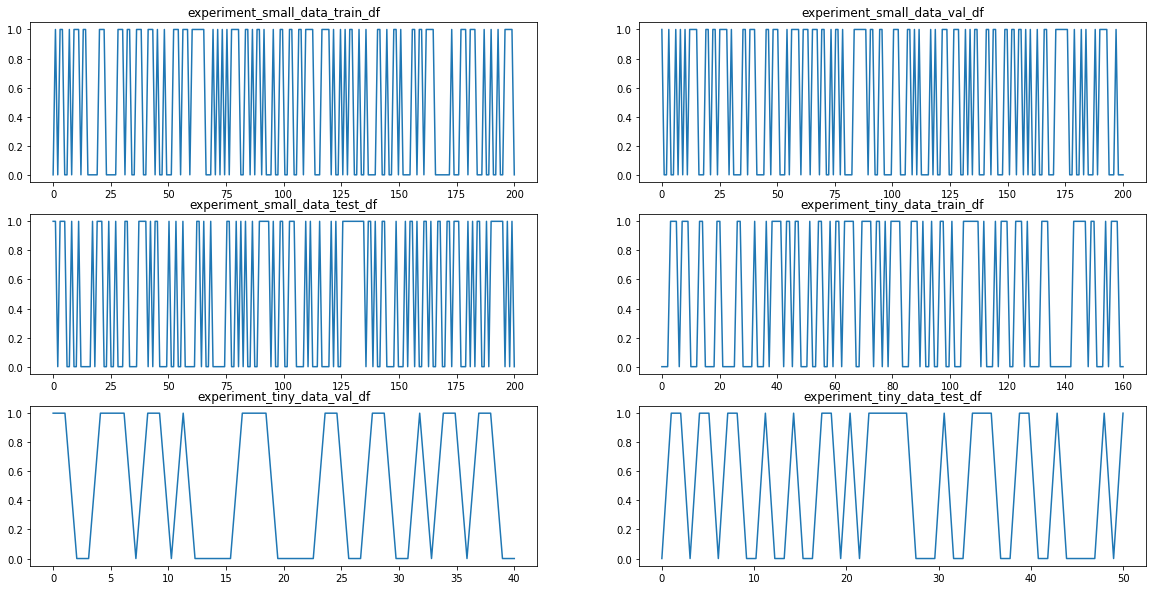

In [96]:
# we will plot the values and see if there is any long horizontal lines that 
# would mean our data is not well shuffled

fig,ax = plt.subplots(3,2,figsize=(20,10))

for key,axis in zip(df_dict,ax.flatten()) : 
    # for better visibily, we will plot a max of 200 points by dataframe
    y = df_dict[key].Label[:min(200,len(df_dict[key]))] 
    x = np.linspace(0,len(y),len(y))
    axis.plot(x,y) 
    axis.set_title(key)

plt.show()

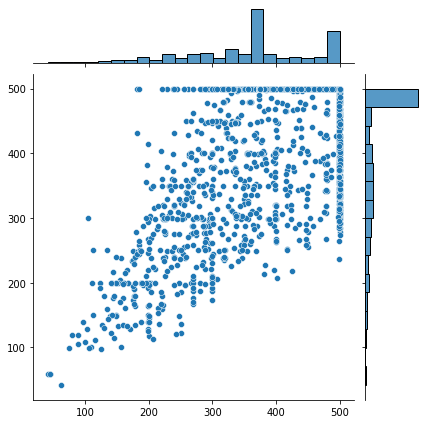

In [97]:
import seaborn as sns

widths=[] 
heights=[]

for image_path in df_dict["experiment_small_data_train_df"]["Path"] :
    w,h,_ = cv2.imread(image_path).shape
    widths.append(w)
    heights.append(h)

for image_path in df_dict["experiment_tiny_data_train_df"]["Path"] :
    w,h,_ = cv2.imread(image_path).shape
    widths.append(w)
    heights.append(h)

sns.jointplot(x=widths,y=heights)
plt.show()

We will be resizing all pictures to 200x200 for the following reasons : 
- We want to decrease the size more than we are increasing it since picture tend to lose details when increasing their dimensions
- The majority of the images seem close to the 1:1 ratio 
- That's as low as we can go to keep most of the image quality and save on computing time and power.

We will also let go of any pictures that have one or both dimensions lower than 100px, those images are both too small and too likely to lose any kind of image quality when increased all the way to twice their size or more. 

In [98]:
SIZE = 200

def create_dataset(key): 
    df = df_dict[key] 
    images = []
    numbers = []
    heights = [] 
    widths = []
    for img_path in df["Path"]: 
        image_number = img_path.split("/")[-1].split(".")[1]
        img = cv2.imread(img_path)
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # switching the coloring code to RGB
        images.append(img)
        numbers.append(image_number)
    df["Image_number"] = numbers 
    df["Image"] = images
    df["Width"] = widths 
    df["Height"] = heights

    return df 

for key in df_dict : 
    length = len(df_dict[key])
    df_dict[key] = create_dataset(key)
    df_dict[key] = df_dict[key][df_dict[key]["Width"]>=100]
    df_dict[key] = df_dict[key][df_dict[key]["Height"]>=100]
    print(f"Removed {length - len(df_dict[key])} rows from {key}")


Removed 10 rows from experiment_small_data_train_df
Removed 7 rows from experiment_small_data_val_df
Removed 4 rows from experiment_small_data_test_df
Removed 1 rows from experiment_tiny_data_train_df
Removed 0 rows from experiment_tiny_data_val_df
Removed 0 rows from experiment_tiny_data_test_df


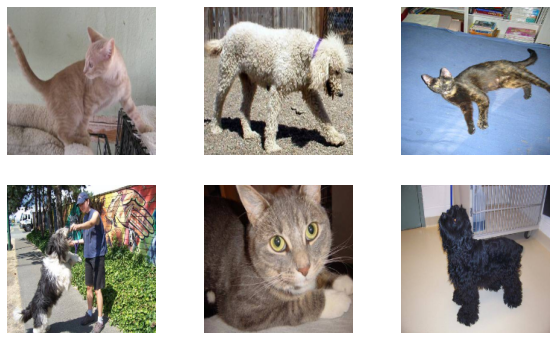

In [99]:
def plot_random_image(df,ax): 
    img = df["Image"][random.randint(0,len(df)-1)] 
    ax.imshow(img)
    ax.axis("off")

fig,ax = plt.subplots(2,3,figsize=(10,6))

for key,axis in zip(df_dict,ax.flatten()): 
    plot_random_image(df_dict[key],axis)

In [103]:
# data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

for key in df_dict : 
    if "train" in key.split("_"): 
        image_list = np.array(df_dict[key]["Image"])
        labels = np.array(df_dict[key]["Label"])
        for image,label in zip(image_list,labels) : 
            print(image.shape , label)




(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 1
(200, 200, 3) 0
(200, 200, 3) 1
(200, 200, 3) 1
(200, 20